In [1]:
# Import libraries
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load data and change datetime
def load_and_prepare_data(filepath):
    weather = pd.read_csv(filepath)
    weather["date"] = pd.to_datetime(weather["date"], format="%Y%m%d")
    weather["year"] = weather["date"].dt.year
    weather["month"] = weather["date"].dt.month
    return weather

In [3]:
def aggregate_monthly_metrics(weather):
    metrics = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
    return weather.groupby(['year', 'month'], as_index=False)[metrics].mean()

In [4]:
# Visualize the data
def visualize_data(weather, weather_per_month):
    sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)
    plt.title("Mean Temperature Over Time")
    plt.show()
    
    sns.heatmap(weather.corr(), annot=True, cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")
    plt.show()

In [5]:
# Preprocess the data
def preprocess_features(weather, features, target):
    weather = weather.dropna(subset=[target])
    X = weather[features]
    y = weather[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [6]:
def train_and_log_models(X_train, X_test, y_train, y_test, depths=[1, 2, 10]):
    for idx, depth in enumerate(depths):
        with mlflow.start_run(run_name=f"run_{idx}"):
            lin_reg = LinearRegression().fit(X_train, y_train)
            tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
            forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)

            mlflow.sklearn.log_model(lin_reg, "lin_reg")
            mlflow.sklearn.log_model(tree_reg, "tree_reg")
            mlflow.sklearn.log_model(forest_reg, "forest_reg")

            mlflow.log_param("max_depth", depth)

            mlflow.log_metric("rmse_lr", mean_squared_error(y_test, lin_reg.predict(X_test), squared=False))
            mlflow.log_metric("rmse_tr", mean_squared_error(y_test, tree_reg.predict(X_test), squared=False))
            mlflow.log_metric("rmse_fr", mean_squared_error(y_test, forest_reg.predict(X_test), squared=False))

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15341 non-null  datetime64[ns]
 1   cloud_cover       15322 non-null  float64       
 2   sunshine          15341 non-null  float64       
 3   global_radiation  15322 non-null  float64       
 4   max_temp          15335 non-null  float64       
 5   mean_temp         15305 non-null  float64       
 6   min_temp          15339 non-null  float64       
 7   precipitation     15335 non-null  float64       
 8   pressure          15337 non-null  float64       
 9   snow_depth        13900 non-null  float64       
 10  year              15341 non-null  int32         
 11  month             15341 non-null  int32         
dtypes: datetime64[ns](1), float64(9), int32(2)
memory usage: 1.3 MB
None


/tmp/ipykernel_180/779146453.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)


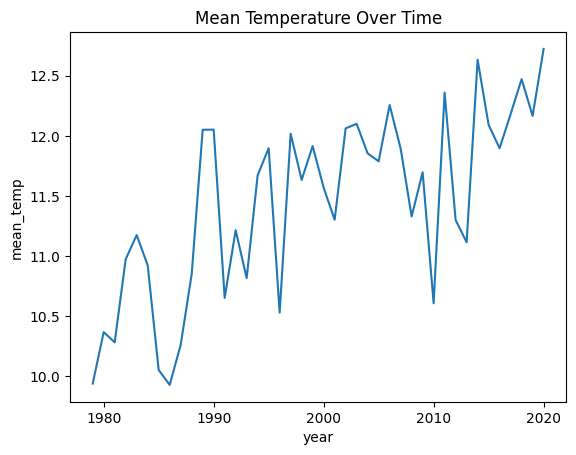

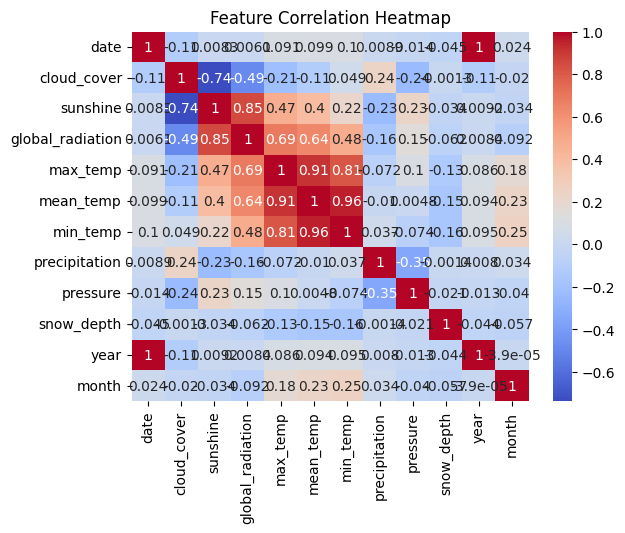

2025/05/12 12:44:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/12 12:44:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/12 12:44:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


TypeError: got an unexpected keyword argument 'squared'

In [7]:
def main():
    filepath = "data/london_weather.csv"
    weather = load_and_prepare_data(filepath)
    print("Data Info:")
    print(weather.info())

    weather_per_month = aggregate_monthly_metrics(weather)
    visualize_data(weather, weather_per_month)

    features = ['month', 'cloud_cover', 'sunshine', 'precipitation', 'pressure', 'global_radiation']
    target = 'mean_temp'
    X_train, X_test, y_train, y_test = preprocess_features(weather, features, target)

    train_and_log_models(X_train, X_test, y_train, y_test)
    print("MLflow experiment results:")
    print(mlflow.search_runs())


if __name__ == "__main__":
    main()